 I’m importing and combining multiple .txt files containing trade data from a specific folder. I read each file into a DataFrame, clean the time column by removing the "IST" string, and convert it to a proper datetime format with timezone awareness. I then concatenate all the DataFrames into one, sort the data by time, and set the time column as the index for easier time-series analysis. Finally, I print the first few rows to verify the output.

In [3]:
import pandas as pd
import glob
import os

folder_path  = "/content/drive/MyDrive/quantdata/Data/aggTrade"

all_files = glob.glob(os.path.join(folder_path, "*.txt"))

df_list = []

for file in all_files:
  df = pd.read_csv(file)
  df['Time'] = df['Time'].str.replace(" IST", "", regex=False)
  df['Time'] = pd.to_datetime(df['Time'], utc=True)
  df_list.append(df)

aggTrade_df = pd.concat(df_list, ignore_index=True)
aggTrade_df.sort_values('Time', inplace=True)
aggTrade_df.set_index('Time', inplace=True)

print(aggTrade_df.head())

                                      Price  Quantity  IsMarketMaker  \
Time                                                                   
2025-03-13 18:30:02.764823793+00:00  579.41     0.496           True   
2025-03-13 18:30:02.781509697+00:00  579.38     0.013           True   
2025-03-13 18:30:02.805731800+00:00  579.38     0.104           True   
2025-03-13 18:30:03.902576812+00:00  579.34     0.496           True   
2025-03-13 18:30:03.905083833+00:00  579.32     2.739           True   

                                     NumTrades     M  
Time                                                  
2025-03-13 18:30:02.764823793+00:00          1  True  
2025-03-13 18:30:02.781509697+00:00          1  True  
2025-03-13 18:30:02.805731800+00:00          1  True  
2025-03-13 18:30:03.902576812+00:00          1  True  
2025-03-13 18:30:03.905083833+00:00          2  True  


I’m loading all .txt files from a specified folder containing depth data. I read each file into a DataFrame, clean and convert the 'Time' column to a datetime format with UTC, and store all the individual DataFrames in a list. Then, I concatenate them into a single DataFrame, sort the rows by time, and set the 'Time' column as the index to prepare it for time-series analysis.

In [4]:
import pandas as pd
import glob

folder_path  = "/content/drive/MyDrive/quantdata/Data/depth20_1000ms"

all_files = glob.glob(os.path.join(folder_path, "*.txt"))

df_list = []

for file in all_files:
  df = pd.read_csv(file)
  df['Time'] = df['Time'].str.replace(" IST", "", regex=False)
  df['Time'] = pd.to_datetime(df['Time'], utc=True)
  df_list.append(df)

depth_df = pd.concat(df_list, ignore_index=True)
depth_df.sort_values('Time', inplace=True)
depth_df.set_index('Time', inplace=True)

print(depth_df.head())

                                     BidPriceL20  BidQtyL20  BidPriceL19  \
Time                                                                       
2025-03-13 18:30:02.292522546+00:00       579.20      0.621       579.24   
2025-03-13 18:30:03.292828523+00:00       579.08      2.612       579.09   
2025-03-13 18:30:04.292889586+00:00       579.14      1.948       579.15   
2025-03-13 18:30:05.292551566+00:00       579.07      0.013       579.08   
2025-03-13 18:30:06.292725093+00:00       579.11      9.143       579.12   

                                     BidQtyL19  BidPriceL18  BidQtyL18  \
Time                                                                     
2025-03-13 18:30:02.292522546+00:00      0.015       579.25      0.009   
2025-03-13 18:30:03.292828523+00:00      8.606       579.10      3.453   
2025-03-13 18:30:04.292889586+00:00      3.957       579.18      1.681   
2025-03-13 18:30:05.292551566+00:00      0.013       579.09      8.606   
2025-03-13 18:30:06.292

I'm analyzinng the shapes of the  generated dataframes containing trade and orderbook data

In [5]:
print(aggTrade_df.shape)
print(depth_df.shape)

(933417, 5)
(338519, 80)


I’m engineering features from both the trade and order book data to construct a comprehensive dataset that captures short-term market dynamics. I aggregate trades and order book updates into 10-second intervals to calculate metrics like volume, VWAP, spread, mid-price returns, depth slopes, and liquidity imbalance. I also compute custom features like volume imbalance and trade wipe level to reflect buying/selling pressure and how aggressively trades consume the order book. Finally, I merge all these features into a single DataFrame and compute short-term volatility to prepare the data for clustering or regime detection.

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


agg_trade_features = {
    'TotalVolume': aggTrade_df['Quantity'].resample('10S').sum(),
    'BuyVolume': aggTrade_df[aggTrade_df['IsMarketMaker'] == False]['Quantity'].resample('10S').sum(),
    'SellVolume': aggTrade_df[aggTrade_df['IsMarketMaker'] == True]['Quantity'].resample('10S').sum(),
    'VWAP': (aggTrade_df['Price'] * aggTrade_df['Quantity']).resample('10S').sum() /
            aggTrade_df['Quantity'].resample('10S').sum(),
    'TradeCount': aggTrade_df['NumTrades'].resample('10S').sum()
}

agg_trade_df = pd.DataFrame(agg_trade_features)
agg_trade_df['VolumeImbalance'] = (agg_trade_df['BuyVolume'] - agg_trade_df['SellVolume']) / \
                                   (agg_trade_df['BuyVolume'] + agg_trade_df['SellVolume'] + 1e-8)
agg_trade_df['VWAPShift'] = agg_trade_df['VWAP'].diff()


depth_df['Spread'] = depth_df['AskPriceL1'] - depth_df['BidPriceL1']
depth_df['ImbalanceL1'] = (depth_df['BidQtyL1'] - depth_df['AskQtyL1']) / \
                          (depth_df['BidQtyL1'] + depth_df['AskQtyL1'] + 1e-8)
depth_df['Microprice'] = (depth_df['BidPriceL1'] * depth_df['AskQtyL1'] +
                          depth_df['AskPriceL1'] * depth_df['BidQtyL1']) / \
                         (depth_df['BidQtyL1'] + depth_df['AskQtyL1'] + 1e-8)
depth_df['CumBidQty'] = depth_df[[f'BidQtyL{i}' for i in range(1, 21)]].sum(axis=1)
depth_df['CumAskQty'] = depth_df[[f'AskQtyL{i}' for i in range(1, 21)]].sum(axis=1)
depth_df['MidPrice'] = (depth_df['AskPriceL1'] + depth_df['BidPriceL1']) / 2
depth_df['MidReturn'] = np.log(depth_df['MidPrice'] / depth_df['MidPrice'].shift(1))

# --- Sloped Depth Calculation ---
def compute_slope(qties):
    x = np.arange(1, len(qties) + 1).reshape(-1, 1)
    y = np.array(qties).reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    return reg.coef_[0][0]

depth_df['BidSlope'] = depth_df[[f'BidQtyL{i}' for i in range(1, 11)]].apply(compute_slope, axis=1)
depth_df['AskSlope'] = depth_df[[f'AskQtyL{i}' for i in range(1, 11)]].apply(compute_slope, axis=1)

# --- Trade Wipe Level ---
# Calculate best ask and bid prices from depth
depth_df['BestBid'] = depth_df['BidPriceL1']
depth_df['BestAsk'] = depth_df['AskPriceL1']

# Interpolate best bid/ask into aggTrade_df timestamps
aggTrade_df['BestBid'] = depth_df['BestBid'].reindex(depth_df.index.union(aggTrade_df.index)).sort_index().interpolate('time').reindex(aggTrade_df.index)
aggTrade_df['BestAsk'] = depth_df['BestAsk'].reindex(depth_df.index.union(aggTrade_df.index)).sort_index().interpolate('time').reindex(aggTrade_df.index)

# Compute how far into the book the price moved
def wipe_level(row):
    if row['Price'] >= row['BestAsk']:  # Buy trade
        return np.clip((row['Price'] - row['BestAsk']) / (row['BestAsk'] * 0.0001), 0, 20)
    elif row['Price'] <= row['BestBid']:  # Sell trade
        return np.clip((row['BestBid'] - row['Price']) / (row['BestBid'] * 0.0001), 0, 20)
    return 0

aggTrade_df['TradeWipeLevel'] = aggTrade_df.apply(wipe_level, axis=1)
trade_wipe_10s = aggTrade_df['TradeWipeLevel'].resample('10S').mean()


depth_features = depth_df[['Spread', 'ImbalanceL1', 'Microprice', 'CumBidQty', 'CumAskQty',
                           'MidReturn', 'BidSlope', 'AskSlope']]
depth_features_10s = depth_features.resample('10S').mean()


full_features = pd.merge(agg_trade_df, depth_features_10s, left_index=True, right_index=True, how='inner')
full_features['TradeWipeLevel'] = trade_wipe_10s


mid_return_10s_std = depth_df['MidReturn'].rolling('10S').std().resample('10S').mean()
mid_return_30s_std = depth_df['MidReturn'].rolling('30S').std().resample('10S').mean()

full_features['MidReturnVol_10s'] = mid_return_10s_std
full_features['MidReturnVol_30s'] = mid_return_30s_std


full_features.dropna(inplace=True)
full_features.head()


<ipython-input-6-d3f15f12199c>:54: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'TotalVolume': aggTrade_df['Quantity'].resample('10S').sum(),
<ipython-input-6-d3f15f12199c>:55: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'BuyVolume': aggTrade_df[aggTrade_df['IsMarketMaker'] == False]['Quantity'].resample('10S').sum(),
<ipython-input-6-d3f15f12199c>:56: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'SellVolume': aggTrade_df[aggTrade_df['IsMarketMaker'] == True]['Quantity'].resample('10S').sum(),
<ipython-input-6-d3f15f12199c>:57: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'VWAP': (aggTrade_df['Price'] * aggTrade_df['Quantity']).resample('10S').sum() /
<ipython-input-6-d3f15f12199c>:58: FutureWarning: 'S' is deprecated and will be removed in a future version, please use

,TotalVolume,BuyVolume,SellVolume,VWAP,TradeCount,VolumeImbalance,VWAPShift,Spread,ImbalanceL1,Microprice,CumBidQty,CumAskQty,MidReturn,BidSlope,AskSlope,TradeWipeLevel,MidReturnVol_10s,MidReturnVol_30s
Time,,,,,,,,,,,,,,,,,,
2025-03-13 18:30:10+00:00,234.228,15.512,218.716,579.255209,65,-0.867548,-0.071510,0.078,0.229023,579.233029,55.0596,59.1893,-0.000035,0.228810,0.279447,0.051901,0.000098,0.000094
2025-03-13 18:30:20+00:00,25.983,9.226,16.757,578.893652,51,-0.289843,-0.361557,0.080,0.043716,578.924470,53.9918,52.1657,-0.000051,0.359293,0.216282,0.206323,0.000127,0.000108
2025-03-13 18:30:30+00:00,27.649,9.417,18.232,578.790021,56,-0.318818,-0.103630,0.080,0.095591,578.802484,51.5648,60.8771,-0.000024,0.490664,0.143172,0.077267,0.000137,0.000120
2025-03-13 18:30:40+00:00,12.784,10.862,1.922,578.763934,14,0.699312,-0.026088,0.062,-0.029999,578.740820,68.5815,49.8978,0.000005,0.350372,0.070325,0.000000,0.000085,0.000116
2025-03-13 18:30:50+00:00,12.414,10.288,2.126,578.640228,23,0.657483,-0.123706,0.072,-0.091395,578.645224,52.3519,54.0896,-0.000015,0.376208,0.200322,0.000000,0.000090,0.000106


I'm analyzing the shape of the final dataframe that is generated after combining the two initial dataframes and filtering out unnecessary columns.

In [7]:
print(full_features.shape)

(32334, 18)


I’m standardizing my feature data so each column has a mean of 0 and standard deviation of 1. Then, I’m applying PCA to reduce dimensionality while retaining 95% of the variance. Finally, I’m plotting how much cumulative variance is explained as I increase the number of principal components to understand how much information is preserved.

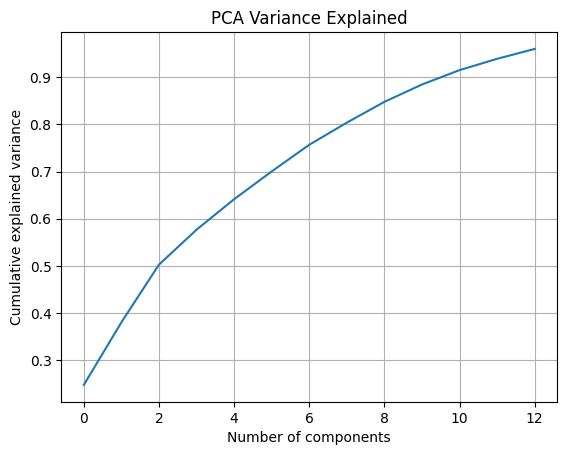

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
normalized_features = scaler.fit_transform(full_features)


pca = PCA(n_components=0.95)
reduced_features = pca.fit_transform(normalized_features)


import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Variance Explained")
plt.grid()
plt.show()


I'm analyzing the shape of the normalized features and the reduces features, i'm going to use the reduced features and applying vrious clustering algorithms on them.

In [9]:
print(normalized_features.shape)
print(reduced_features.shape)

(32334, 18)
(32334, 13)


I'm printing the normalized and reduced features respectively.

In [10]:
print(normalized_features)
print(reduced_features)

[[ 3.36866220e+00  7.92874304e-02  5.36938007e+00 ... -4.74239899e-01
   4.93451632e-01  3.28028783e-01]
 [ 5.83739444e-04 -9.87184720e-02  9.20372636e-02 ...  2.56314753e-02
   1.11160975e+00  6.69378483e-01]
 [ 2.75290141e-02 -9.33097658e-02  1.30580139e-01 ... -3.92128880e-01
   1.33218876e+00  9.39448559e-01]
 ...
 [-3.82521135e-01 -3.18379908e-01 -3.24225794e-01 ... -6.42244202e-01
  -4.28345479e-01 -5.49875904e-01]
 [-4.08043130e-01 -3.39646601e-01 -3.45835935e-01 ... -3.20095286e-01
  -1.12428391e+00 -7.18298543e-01]
 [-2.33659005e-01 -2.67294536e-01 -1.30858147e-01 ... -6.42244202e-01
  -5.61808542e-01 -8.02397886e-01]]
[[ 2.88170737 -3.77752391 -1.78371875 ... -2.773496   -2.76923608
   1.07343023]
 [ 0.18954605 -1.50586372 -2.33741345 ... -0.44741509  0.11500871
   0.76803947]
 [ 0.26884475 -1.20588574 -0.8685865  ... -0.55731315 -0.04991189
   0.60212343]
 ...
 [-0.41249283  2.0354254   0.42190647 ... -0.34831203  0.0566678
  -0.65418593]
 [-0.56548521  2.06101398  0.6387085

 I’m performing unsupervised clustering and regime labeling on market microstructure data to uncover distinct patterns of market behavior over time. I begin by importing the necessary libraries for clustering, evaluation, dimensionality reduction, and visualization.

I first apply KMeans clustering across a range of cluster counts and compute the inertia for each to plot the Elbow Curve. This helps me visually identify an optimal number of clusters by looking for the “elbow” point where the inertia starts decreasing more slowly. Based on this, I choose 4 clusters for KMeans and fit the model.

Next, I apply two other clustering algorithms: HDBSCAN, which is density-based and automatically determines the number of clusters, and Gaussian Mixture Models (GMM), which assume that data comes from a mixture of Gaussian distributions. I then compare the quality of all three clustering methods using Silhouette Score and Davies-Bouldin Index — higher Silhouette and lower DB indicate better-defined clusters. HDBSCAN performs best according to these metrics.

I assign the HDBSCAN cluster labels to my data and compute the average value of key features (Spread, Volatility, CumBidQty, Imbalance) per regime to characterize each regime statistically. Using domain knowledge, I define thresholds for volatility, spread, and volume imbalance. These thresholds help me create human-readable names for each regime based on whether each feature is high or low.

I then visualize the clusters in 2D using t-SNE, a technique that preserves local structure when projecting high-dimensional data down to two dimensions. This lets me see how well-separated the clusters are. I also plot how regimes evolve over time, which helps me understand transitions in market behavior during the trading session.

Finally, I construct a transition matrix that captures the probability of moving from one regime to another in consecutive time intervals. This transition matrix gives me insight into the temporal stability of each regime and how likely the market is to switch from one type of behavior to another.

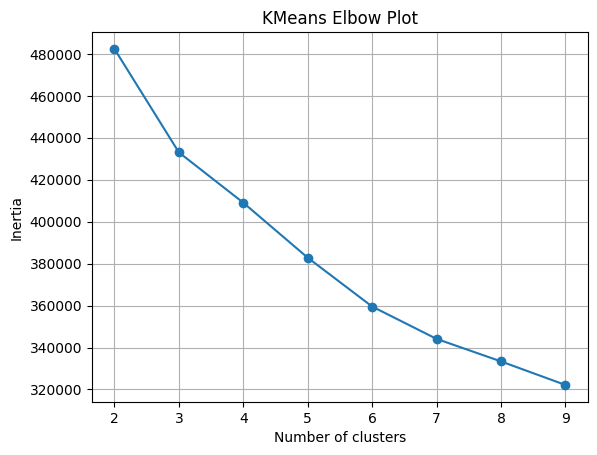

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette (KMeans): 0.2319689725309735
DB Index (KMeans): 1.5627006110049133
Silhouette (GMM): 0.11679181560701923
DB Index (GMM): 2.6531018507557658
Silhouette (HDBSCAN): 0.36502986255801306
DB Index (HDBSCAN): 0.6809970938860529
Regime Stats:
           Spread  MidReturnVol_10s  CumBidQty  VolumeImbalance
Regime                                                        
-1      0.075922          0.000081  67.974885        -0.016670
 0      0.055330          0.000051  54.475144        -0.077489
 1      0.092669          0.000067  46.096780         0.810905
 2      0.088208          0.000065  47.490704        -0.606999


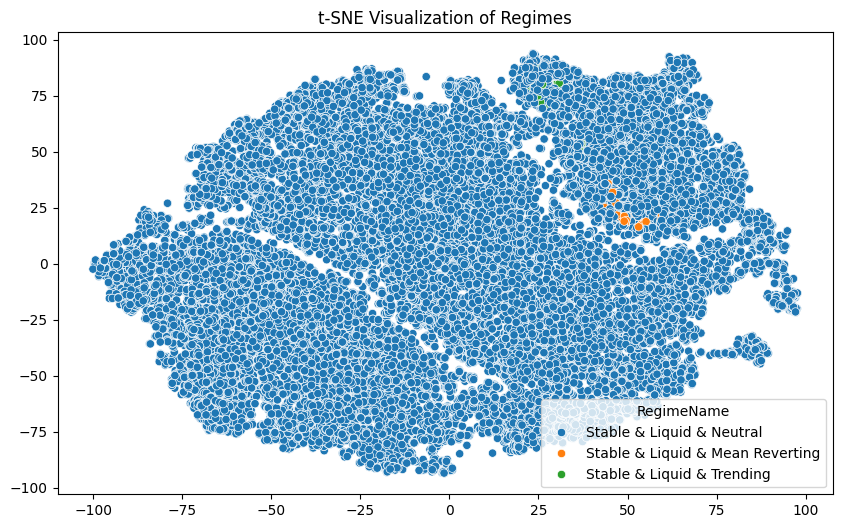

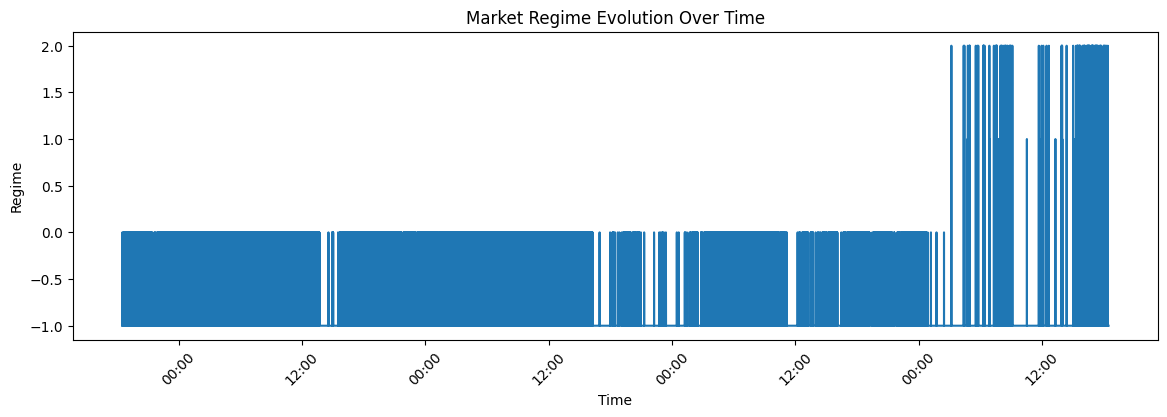

Regime Transition Probabilities:
                                  Stable & Liquid & Neutral  \
Stable & Liquid & Neutral                              1.00   
Stable & Liquid & Mean Reverting                       0.91   
Stable & Liquid & Trending                             0.93   

                                  Stable & Liquid & Mean Reverting  \
Stable & Liquid & Neutral                                     0.00   
Stable & Liquid & Mean Reverting                              0.05   
Stable & Liquid & Trending                                    0.05   

                                  Stable & Liquid & Trending  
Stable & Liquid & Neutral                               0.00  
Stable & Liquid & Mean Reverting                        0.05  
Stable & Liquid & Trending                              0.02  


In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# KMeans Elbow Plot
inertias = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(reduced_features)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Plot")
plt.grid(True)
plt.show()

# Final KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_features)

# HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30)
hdb_labels = hdb.fit_predict(reduced_features)

# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(reduced_features)

# Evaluate KMeans
print("Silhouette (KMeans):", silhouette_score(reduced_features, kmeans_labels))
print("DB Index (KMeans):", davies_bouldin_score(reduced_features, kmeans_labels))

# Evaluate GMM
print("Silhouette (GMM):", silhouette_score(reduced_features, gmm_labels))
print("DB Index (GMM):", davies_bouldin_score(reduced_features, gmm_labels))

# Evaluate HDBSCAN (excluding noise)
mask = hdb_labels != -1
if np.sum(mask) > 1:
    sil_hdb = silhouette_score(reduced_features[mask], hdb_labels[mask])
    db_hdb = davies_bouldin_score(reduced_features[mask], hdb_labels[mask])
    print("Silhouette (HDBSCAN):", sil_hdb)
    print("DB Index (HDBSCAN):", db_hdb)
else:
    print("Not enough non-noise points to compute scores for HDBSCAN.")

# Assign regime labels from HDBSCAN
full_features['Regime'] = hdb_labels

# Compute regime-wise statistics
features_used = ['Spread', 'MidReturnVol_10s', 'CumBidQty', 'VolumeImbalance']
regime_stats = full_features.groupby('Regime')[features_used].mean()
print("Regime Stats:\n", regime_stats)

# Define thresholds based on quantiles
'''threshold_vol = full_features['MidReturnVol_10s'].quantile(0.7)
threshold_spread = full_features['Spread'].quantile(0.7)
imbalance_threshold = full_features['VolumeImbalance'].quantile(0.6)'''

# Domain-based thresholds
'''threshold_vol = full_features['MidReturnVol_10s'].mean() + full_features['MidReturnVol_10s'].std()
normal_hours_spread = full_features['Spread'].mean()  # You might want to filter for specific hours
threshold_spread = normal_hours_spread * 1.5
imbalance_threshold = 0  # Natural division between buying and selling pressure'''

'''threshold_vol = full_features['MidReturnVol_10s'].median() * 1.75
liquid_hours_mask = (full_features.index.hour >= 9) & (full_features.index.hour < 16)
baseline_spread = full_features.loc[liquid_hours_mask, 'Spread'].median()
threshold_spread = baseline_spread * 2.0
trending_threshold = 0.3    # buy pressure
reverting_threshold = -0.3  # sell pressure'''

threshold_vol = full_features['MidReturnVol_10s'].quantile(0.7)
liquid_hours_mask = (full_features.index.hour >= 9) & (full_features.index.hour < 16)
baseline_spread = full_features.loc[liquid_hours_mask, 'Spread'].median()
threshold_spread = baseline_spread * 1.5
trending_threshold = full_features['VolumeImbalance'].quantile(0.7)
reverting_threshold = full_features['VolumeImbalance'].quantile(0.3)


# Auto-naming function
def auto_name_regime(row):
    name_parts = []
    if row['MidReturnVol_10s'] > threshold_vol:
        name_parts.append('Volatile')
    else:
        name_parts.append('Stable')

    if row['Spread'] > threshold_spread:
        name_parts.append('Illiquid')
    else:
        name_parts.append('Liquid')

    '''if row['VolumeImbalance'] > imbalance_threshold:
        name_parts.append('Trending')
    else:
        name_parts.append('Mean Reverting')'''
    if row['VolumeImbalance'] > trending_threshold:
        name_parts.append('Trending')
    elif row['VolumeImbalance'] < reverting_threshold:
        name_parts.append('Mean Reverting')
    else:
        name_parts.append('Neutral')

    return " & ".join(name_parts)

# Apply auto-naming
regime_names_auto = regime_stats.apply(auto_name_regime, axis=1)
auto_name_mapping = dict(zip(regime_stats.index, regime_names_auto))
full_features['RegimeName'] = full_features['Regime'].map(auto_name_mapping)

# t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(reduced_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=full_features['RegimeName'], palette="tab10")
plt.title("t-SNE Visualization of Regimes")
plt.show()

# Regime evolution plot
full_features['Time'] = full_features.index
plt.figure(figsize=(14, 4))
sns.lineplot(x='Time', y='Regime', data=full_features)
plt.title("Market Regime Evolution Over Time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.show()

# Regime transitions
regimes = full_features['RegimeName'].values
transition_matrix = {}

for i in range(1, len(regimes)):
    prev = regimes[i - 1]
    curr = regimes[i]
    if prev not in transition_matrix:
        transition_matrix[prev] = {}
    if curr not in transition_matrix[prev]:
        transition_matrix[prev][curr] = 0
    transition_matrix[prev][curr] += 1

# Convert to probabilities
for prev in transition_matrix:
    total = sum(transition_matrix[prev].values())
    for curr in transition_matrix[prev]:
        transition_matrix[prev][curr] /= total

trans_df = pd.DataFrame(transition_matrix).fillna(0)
print("Regime Transition Probabilities:")
print(trans_df.T.round(2))
